In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras import backend as K
import cv2
import datagen
import ensemble_functions
import model as unet_model_script
import random
import matplotlib.pyplot as plt
from matplotlib import pyplot
import importlib
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve

Using TensorFlow backend.


In [2]:
importlib.reload(datagen)
importlib.reload(unet_model_script)
importlib.reload(ensemble_functions)

<module 'ensemble_functions' from 'C:\\Users\\krcma\\Desktop\\tf_segmentation\\unet_segmentation\\ensemble_functions.py'>

In [3]:
image_size = 240
num_slices = 155
num_patients = 33

In [4]:
x_val, y_val = datagen.get_whole_patient(number=3, # num_patients
                    file_path='../dataset/', 
                    mode='test', 
                    glioma_type=['HGG'], 
                    image_size=240                     
                    )

In [5]:
ensemble_functions.evaluate_ensemble(x_val, y_val, "../models/base_d_5/", "3_ensemble", num_patients, image_size, None, 0)

{'enhancing': {'mean': 59.32, 'stdDev': 26.93, 'median': 70.07},
 'whole': {'mean': 81.94, 'stdDev': 11.45, 'median': 84.76},
 'core': {'mean': 59.81, 'stdDev': 23.37, 'median': 65.85}}

# Image postprocessing

In [26]:
 tumor_regions = ["enhancing", "whole", "core"]

In [31]:
ar = [
{'enhancing': {'mean': 10.73, 'stdDev': 11.54, 'median': 5.38},
 'whole': {'mean': 55.14, 'stdDev': 11.69, 'median': 55.66},
 'core': {'mean': 22.25, 'stdDev': 19.88, 'median': 16.52}},
{'enhancing': {'mean': 17.97, 'stdDev': 20.49, 'median': 8.85},
 'whole': {'mean': 60.88, 'stdDev': 15.23, 'median': 61.68},
 'core': {'mean': 22.63, 'stdDev': 21.73, 'median': 15.1}},
{'enhancing': {'mean': 41.49, 'stdDev': 22.29, 'median': 39.86},
 'whole': {'mean': 70.04, 'stdDev': 14.18, 'median': 71.27},
 'core': {'mean': 31.81, 'stdDev': 20.08, 'median': 27.83}}
]

In [32]:
ensemble_functions.cross_val_avg(tumor_regions, ar)

{'enhancing': {'mean': 23.4, 'stdDev': 18.11, 'median': 18.03},
 'whole': {'mean': 62.02, 'stdDev': 13.7, 'median': 62.87},
 'core': {'mean': 25.56, 'stdDev': 20.56, 'median': 19.82}}

In [5]:
patient = 2

In [6]:
models = {} # ensemble_functions.get_models("../models/base_d_5_new/", "3_ensemble", 1, 4, verbose=0)

In [7]:
for i in range(1,5):
    models[i] = keras.models.load_model("../models/base_d_5/1_ensemble_{}.h5".format(i))

In [8]:
predictions = {}
for i in range(1,5):
    predictions[i] = models[i].predict(x_val[patient])

In [9]:
final_mask = ensemble_functions.create_mask(predictions, 155, image_size, p=None)

In [10]:
final_mask.shape

(155, 1, 240, 240)

In [ ]:
slic = 68

f, axarr = plt.subplots(2,3, figsize=(8, 8)) 
axarr[0,0].imshow(datagen.convert_labels_eval(final_mask, "whole", image_size)[slic][0])
axarr[0,1].imshow(datagen.convert_labels_eval(final_mask, "core", image_size)[slic][0])
axarr[0,2].imshow(datagen.convert_labels_eval(final_mask, "enhancing", image_size)[slic][0])

axarr[1,0].imshow(datagen.convert_labels_eval(y_val[patient][0], "whole", image_size)[slic][0])
axarr[1,1].imshow(datagen.convert_labels_eval(y_val[patient][0], "core", image_size)[slic][0])
axarr[1,2].imshow(datagen.convert_labels_eval(y_val[patient][0], "enhancing", image_size)[slic][0])

87


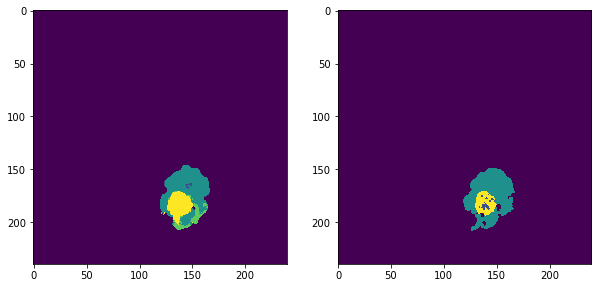

In [25]:
slic = random.randint(60, 100)
print(slic)
# slic=100
f, axarr = plt.subplots(1,2, figsize=(10,10))
axarr[0].imshow(final_mask[slic][0])
axarr[1].imshow(y_val[patient][0][slic][0])

In [12]:
x_val[patient].shape

(155, 4, 240, 240)